In [5]:

%load_ext autoreload
%autoreload 2

import sys

sys.path.insert(0, ".")

import math
import numpy as np
import pandas as pd
import arviz as az
import matplotlib.pyplot as plt
from scipy.stats import lognorm
from scipy.stats import norm
from scipy.special import logsumexp
from scipy.optimize import minimize
import datetime

from scipy.stats import gamma
from sklearn import linear_model
from patsy import dmatrix, cr
import statsmodels.api as sm

%matplotlib inline
import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
import random
random.seed(2222)

## Load and prepare data

In [83]:
lob = "WC"

In [84]:
min_years = 5
ep_max = 2e9
ep_min = 25e6

num_size_groups = 3
year_groups = [range(1991, 1996), range(1996, 2001), range(2001, 2006), range(2006, 2011)]

# exclude companies with very large errors (compared to sqrt avg premium volume)
tags_excl = {
    "WC": ["SPSF.36196", "SPSF.00691", "SPSF.00070"],
    "OO": ["SPSF.00078", "SPSF.42439", "SPSF.00070", "SPSF.00507", "SPSF.02127", "SPSF.11371"],
    "CA": ["SPSF.24139"],
    "OC": ["SPSF.15792", "SPSF.36706", "SPSF.11268"]
}

# WC companies
# (these companies do mostly WC, but have identical rows showing up in other lobs)
wc_cpns = ["SPSF.00011", "SPSF.00031", "SPSF.00053", "SPSF.10191", "SPSF.10320", "SPSF.10385", "SPSF.10699", "SPSF.10781", "SPSF.10998", "SPSF.11030", "SPSF.11039", "SPSF.11149", "SPSF.11347", "SPSF.14216", "SPSF.22350", "SPSF.22945", "SPSF.24017", "SPSF.27626", "SPSF.27677", "SPSF.36129", "SPSF.41190", "SPSF.37869"]

In [85]:
tris_df = pd.read_csv("/users/urikorn/Documents/snl/snl_all.csv")

tris_df["lob"] = tris_df.program_tag.apply(lambda x: x[-2:])
tris_df["tag"] = tris_df.program_tag.apply(lambda x: x[:-2])
tris_df["year"] = tris_df.period_start.apply(lambda x: int(x[:4]))
tris_df["eval_year"] = tris_df.evaluation_date.apply(lambda x: int(x[:4]))
tris_df["paid_lr"] = tris_df.paid_loss / tris_df.earned_premium
tris_df["reported_lr"] = tris_df.reported_loss / tris_df.earned_premium
tris_df["incurred_lr"] = tris_df.incurred_loss / tris_df.earned_premium

tris_df = tris_df[tris_df.year.apply(lambda x: x in range(1990, 2011))]
tris_df = tris_df[tris_df.tag.apply(lambda x: x not in tags_excl[lob])]

tris_df = tris_df[((tris_df.tag.isin(wc_cpns)) & (tris_df.lob == "WC")) | (~tris_df.tag.isin(wc_cpns))]

max_age = tris_df.groupby(["tag", "lob", "year"])["dev_lag"].max().reset_index()
max_age = max_age.rename(columns={"dev_lag": "max_dev_lag"})
tris_df = pd.merge(tris_df, max_age, how="left", on=["tag", "lob", "year"])

init_ult = tris_df[tris_df.dev_lag == 0].groupby(["tag", "lob", "year"])["incurred_lr"].mean().reset_index()
init_ult = init_ult.rename(columns={"incurred_lr": "init_lr"})
tris_df = pd.merge(tris_df, init_ult, how="left", on=["tag", "lob", "year"])

num_yrs = tris_df[(tris_df.dev_lag == 0)].groupby(["tag", "lob"])["year"].count().reset_index()
num_yrs = num_yrs.rename(columns={"year": "num_years"})
tris_df = pd.merge(tris_df, num_yrs, how="left", on=["tag", "lob"])
tris_df = tris_df[tris_df.num_years >= min_years]

tris_df.sort_values(["lob", "tag", "year", "dev_lag"], inplace=True)

np.unique(tris_df.lob)

array(['AD', 'AL', 'CA', 'CM', 'FM', 'FS', 'HO', 'IN', 'MC', 'MO', 'OC',
       'OI', 'OO', 'PC', 'PO', 'PP', 'RF', 'RL', 'RP', 'SL', 'WC'],
      dtype=object)

In [86]:
tris_lob_df = tris_df[tris_df.lob == lob].copy()

In [87]:
lob_prem = tris_lob_df[tris_lob_df.dev_lag == 0].groupby(["tag", "lob"])["earned_premium"].mean().reset_index()
lob_prem = lob_prem.rename(columns={"earned_premium": "lob_prem"})
lob_prem = lob_prem[(lob_prem.lob_prem >= ep_min) & (lob_prem.lob_prem <= ep_max)]
size_cutoffs = np.quantile(lob_prem.lob_prem, np.linspace(0, 1, num_size_groups + 1))
size_cutoffs[0] = size_cutoffs[0] - 1

lob_prem["size_group"] = lob_prem.lob_prem.apply(lambda x: np.where(x <= size_cutoffs)[0][0] - 1)
tris_lob_df = pd.merge(tris_lob_df, lob_prem, how="left", on=["tag", "lob"])
tris_df = pd.merge(tris_df, lob_prem, how="left", on=["tag", "lob"])
tris_lob_df = tris_lob_df[(tris_lob_df.lob_prem >= ep_min) & (tris_lob_df.lob_prem <= ep_max)]

In [88]:
tags = np.unique(tris_lob_df.tag)

In [89]:
mutuals_all = ["SPSF.00011", "SPSF.00028", "SPSF.00031", "SPSF.00037", "SPSF.00051", "SPSF.00052", "SPSF.00078", "SPSF.00221", "SPSF.00280", "SPSF.00301", "SPSF.00317", "SPSF.00353", "SPSF.00361", "SPSF.00415", "SPSF.00428", "SPSF.00438", "SPSF.00447", "SPSF.00451", "SPSF.00457", "SPSF.00468", "SPSF.00473", "SPSF.00507", "SPSF.00634", "SPSF.00655", "SPSF.00662", "SPSF.00726", "SPSF.00742", "SPSF.00764", "SPSF.01090", "SPSF.01112", "SPSF.01236", "SPSF.01244", "SPSF.01406", "SPSF.01694", "SPSF.01767", "SPSF.01848", "SPSF.01953", "SPSF.02011", "SPSF.02038", "SPSF.02054", "SPSF.02070", "SPSF.02143", "SPSF.02224", "SPSF.02348", "SPSF.02500", "SPSF.02917", "SPSF.03034", "SPSF.03778", "SPSF.04130", "SPSF.04731", "SPSF.05185", "SPSF.05339", "SPSF.05428", "SPSF.05690", "SPSF.06408", "SPSF.06459", "SPSF.06947", "SPSF.07625", "SPSF.07757", "SPSF.07870", "SPSF.08001", "SPSF.08079", "SPSF.08427", "SPSF.10191", "SPSF.10320", "SPSF.10323", "SPSF.10385", "SPSF.10476", "SPSF.10653", "SPSF.10719", "SPSF.10720", "SPSF.10751", "SPSF.10831", "SPSF.10913", "SPSF.10941", "SPSF.10949", "SPSF.10989", "SPSF.10998", "SPSF.11036", "SPSF.11091", "SPSF.11101", "SPSF.11149", "SPSF.11186", "SPSF.11268", "SPSF.11347", "SPSF.11617", "SPSF.11753", "SPSF.11878", "SPSF.11964", "SPSF.11972", "SPSF.11973", "SPSF.12362", "SPSF.12372", "SPSF.12468", "SPSF.12839", "SPSF.12988", "SPSF.13098", "SPSF.13374", "SPSF.13420", "SPSF.13471", "SPSF.13501", "SPSF.13528", "SPSF.13684", "SPSF.13692", "SPSF.13714", "SPSF.13725", "SPSF.13889", "SPSF.13919", "SPSF.13935", "SPSF.13943", "SPSF.13978", "SPSF.14001", "SPSF.14036", "SPSF.14044", "SPSF.14090", "SPSF.14141", "SPSF.14176", "SPSF.14184", "SPSF.14362", "SPSF.14400", "SPSF.14427", "SPSF.14443", "SPSF.14451", "SPSF.14494", "SPSF.14508", "SPSF.14656", "SPSF.14753", "SPSF.14761", "SPSF.14885", "SPSF.14915", "SPSF.14974", "SPSF.15024", "SPSF.15040", "SPSF.15067", "SPSF.15091", "SPSF.15113", "SPSF.15261", "SPSF.15296", "SPSF.15350", "SPSF.15377", "SPSF.15407", "SPSF.15881", "SPSF.16250", "SPSF.16273", "SPSF.16330", "SPSF.16489", "SPSF.16683", "SPSF.16748", "SPSF.16799", "SPSF.16888", "SPSF.16918", "SPSF.16985", "SPSF.17043", "SPSF.17299", "SPSF.17329", "SPSF.17450", "SPSF.17493", "SPSF.18309", "SPSF.18767", "SPSF.20672", "SPSF.21270", "SPSF.21415", "SPSF.21482", "SPSF.21733", "SPSF.22624", "SPSF.22945", "SPSF.22993", "SPSF.23388", "SPSF.23574", "SPSF.24017", "SPSF.24341", "SPSF.24520", "SPSF.26034", "SPSF.26257", "SPSF.26468", "SPSF.26818", "SPSF.27022", "SPSF.27065", "SPSF.27480", "SPSF.27529", "SPSF.27766", "SPSF.28681", "SPSF.29513", "SPSF.29610", "SPSF.29831", "SPSF.30376", "SPSF.30384", "SPSF.30449", "SPSF.30651", "SPSF.31186", "SPSF.31780", "SPSF.32522", "SPSF.32832", "SPSF.33049", "SPSF.33200", "SPSF.33677", "SPSF.34150", "SPSF.34606", "SPSF.34703", "SPSF.36188", "SPSF.36277", "SPSF.36340", "SPSF.36706", "SPSF.40070", "SPSF.40940", "SPSF.43320", "SPSF.43850", "SPSF.44377", "SPSF.6947A", "SPSF.6947B"]
non_mutuals = [t for t in tags if t not in mutuals_all]
mutuals = [t for t in tags if t in mutuals_all]
tris_lob_df["mutual"] = tris_lob_df.tag.isin(mutuals)
tris_lob_df["mutual"].value_counts()
(len(mutuals), len(non_mutuals))

(31, 61)

In [90]:
cpn_prem = tris_df[tris_df.dev_lag == 0].groupby(["tag", "lob"])["earned_premium"].mean().reset_index()
cpn_prem = cpn_prem.groupby(["tag"]).sum().reset_index()
cpn_prem = cpn_prem.rename(columns={"earned_premium": "cpn_prem"})
cpn_prem = cpn_prem[cpn_prem.tag.apply(lambda x: x in tags)]
size_cutoffs = np.quantile(cpn_prem.cpn_prem, np.linspace(0, 1, num_size_groups + 1))
size_cutoffs[0] = size_cutoffs[0] - 1

cpn_prem["cpn_size_group"] = cpn_prem.cpn_prem.apply(lambda x: np.where(x <= size_cutoffs)[0][0] - 1)
tris_df = pd.merge(tris_df, cpn_prem, how="left", on=["tag"])
tris_lob_df = pd.merge(tris_lob_df, cpn_prem, how="left", on=["tag"])

lob_prem = pd.merge(lob_prem, cpn_prem, how="left", on="tag")
lob_prem["pct_lob"] = lob_prem.lob_prem / lob_prem.cpn_prem
pct_cutoffs = np.quantile(lob_prem.pct_lob, np.linspace(0, 1, num_size_groups + 1))
pct_cutoffs[0] = pct_cutoffs[0] - 1
lob_prem["pct_group"] = lob_prem.pct_lob.apply(lambda x: np.where(x <= pct_cutoffs)[0][0] - 1)
tris_lob_df = pd.merge(tris_lob_df, lob_prem[["tag", "pct_lob", "pct_group"]])

In [93]:
print(len(set(tris_lob_df.tag)))
print(np.sum(tris_lob_df.earned_premium[tris_lob_df.year == 2010]) / 1e9)

92
186.10356


[3.31887768e+01 3.07225083e+02 9.70476673e+02 7.66407015e+04]
[-0.99615412  0.11329249  0.48882433  1.        ]


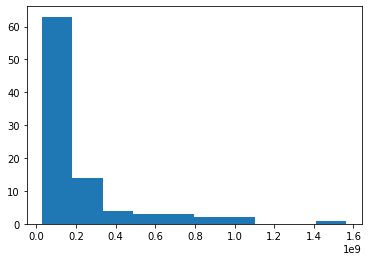

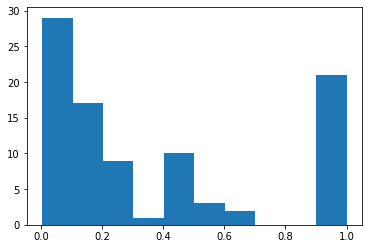

In [94]:
print(size_cutoffs/1e6)
print(pct_cutoffs)

plt.hist(lob_prem.lob_prem)
plt.show()

plt.hist(lob_prem.pct_lob)
plt.show()

Plot all of the LRs

In [95]:
if False:
    for i, t in enumerate(tags):
        f = (tris_lob_df.tag == t) & (tris_lob_df.dev_lag == tris_lob_df.max_dev_lag)
        plt.plot(tris_lob_df.year[f], tris_lob_df.incurred_lr[f], label = i)
    #plt.legend()
    plt.show()

## Fit LDFs for each company to calculate chain ladder ultimates

In [96]:
# SMIPOC model for smoothing LDFs (Korn 2017)
def smipoc(ata, loss, last_age = 25, inits = None, knot = 4):
    # inits = [-5, -2, -2, -1, 0.1]
    ata = np.array(ata)
    ages = (np.array(range(last_age)) + 1) * 12
    ages_fit = ages[:len(ata)]
    
    k = np.log(ages)[knot]
    X = dmatrix("cr(np.log(ages), knots = k, constraints = 'center')")
    X_fit = X[:len(ages_fit),:]

    X_cv = dmatrix("np.log(ages)")
    X_cv_fit = X_cv[:len(ages_fit),:]

    y = [np.maximum(0.0001, i - 1) for i in ata]
        
    def nll(params):
        cv_params = np.array([params[3], 5 * (np.exp(params[4]) / (1 + np.exp(params[4])))])
        ata_fit = np.exp(np.sum(X_fit * params[:3], axis = 1)) + 1
        cv_factor_fit = np.exp(np.sum(X_cv_fit * cv_params, axis = 1))
        cv_fit = cv_factor_fit / np.sqrt(loss)
        alpha = 1 / cv_fit ** 2
        beta = alpha / (ata_fit - 1)
        return - np.sum(gamma.logpdf(y, a = alpha, scale = 1 / beta))

    if inits == None:
        w = [(1 / i) ** 0.25 for i in ages_fit]
        fit_init = linear_model.GammaRegressor(alpha = 0).fit(X_fit[:,1:], y, sample_weight = w)
        inits = [fit_init.intercept_] + list(fit_init.coef_) + list([2, -1])

    fit = minimize(nll, inits)

    ata_fit = np.exp(np.sum(X * fit.x[:3], axis = 1)) + 1
    return ata_fit, fit


In [97]:
# Smooth out the LDFs for each company

atas_emp = []
atas = []
atus = []
atus_map = {}
atas_paid_emp = []
atas_paid = []
atus_paid = []
atus_paid_map = {}

#ldfs = pd.DataFrame({"lob": [], "program_tag": [], "ata": [], "atu": [], "ata_paid": [], "atu_paid": []})

for tag in tags:
    t = tris_lob_df[tris_lob_df.tag == tag]

    ata_emp = [
        np.sum(t.reported_loss[(t.dev_lag == d + 12) & (t.max_dev_lag > d)]) / np.sum(t.reported_loss[(t.dev_lag == d) & (t.max_dev_lag > d)])
        for d in np.unique(t.dev_lag)[:-1]
    ]
    atas_emp += [ata_emp]
    loss = [
        np.sum(t.reported_loss[(t.dev_lag == d) & (t.max_dev_lag > d)]) / 1e6
        for d in np.unique(t.dev_lag)[:-1]
    ]

    ata, _ = smipoc(ata_emp, loss)
    atas += [ata]

    # ensure decreasing
    for i in range(1, len((ata))):
        if ata[i] >= ata[i - 1]:
            ata[i] = ata[i - 1] ** 0.9

    # ensure first point is reasonable
    if ata[0] >= ata_emp[0] * 2:
        ata[0] = ata_emp[0]

    atu = np.flip(np.cumprod(np.flip(ata)))
    atu = np.maximum(0.9, atu)

    atus += [atu]
    atus_map[tag] = atu

    # paid development
    ata_paid_emp = [
        np.sum(t.paid_loss[(t.dev_lag == d + 12) & (t.max_dev_lag > d)]) / np.sum(t.paid_loss[(t.dev_lag == d) & (t.max_dev_lag > d)])
        for d in np.unique(t.dev_lag)[:-1]
    ]
    atas_paid_emp += [ata_paid_emp]
    loss_paid = [
        np.sum(t.paid_loss[(t.dev_lag == d) & (t.max_dev_lag > d)]) / 1e6
        for d in np.unique(t.dev_lag)[:-1]
    ]

    ata_paid, _ = smipoc(ata_paid_emp, loss_paid)

    # ensure decreasing
    for i in range(1, len((ata))):
        if ata_paid[i] >= ata_paid[i - 1]:
            ata_paid[i] = ata_paid[i - 1] ** 0.9

    ata_paid = np.maximum(1.0, ata_paid)

    atas_paid += [ata_paid]

    atu_paid = np.flip(np.cumprod(np.flip(ata_paid)))

    atus_paid += [atu_paid]
    atus_paid_map[tag] = atu_paid
    
atus = np.array(atus) 
atus_paid = np.array(atus_paid) 


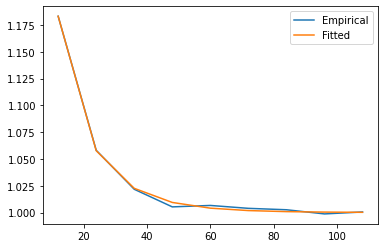

In [98]:
# make sure that the LDF smoothing is working correctly
i = 7
ages = (np.array(range(len(atas_emp[i]))) + 1) * 12
plt.plot(ages, atas_emp[i], label = "Empirical")
plt.plot(ages, atas[i][:len(atas_emp[i])], label = "Fitted")
plt.legend()
plt.show()

In [99]:
tris_lob_df["atu"] = [
    atus_map[prgm][int(dev // 12)] if prgm in list(atus_map.keys()) else 0
    for prgm, dev in zip(tris_lob_df.tag, tris_lob_df.dev_lag)
]
tris_lob_df["ult_cl"] = tris_lob_df.reported_lr * tris_lob_df.atu

In [100]:
ult_true = tris_lob_df[["tag", "lob", "year", "incurred_lr", "ult_cl"]][tris_lob_df.dev_lag == tris_lob_df.max_dev_lag]
ult_true["ult_true"] = [(a + b) / 2 if b > 0 else a for a, b in zip(ult_true.incurred_lr, ult_true.ult_cl)]
ult_true = ult_true[["tag", "lob", "year", "ult_true"]]
tris_lob_df = pd.merge(tris_lob_df, ult_true, how="left", on=["tag", "lob", "year"])
tris_lob_df["bias"] = tris_lob_df.ult_true / tris_lob_df.init_lr - 1

In [101]:
# remove any extreme outliers
tris_lob_df = tris_lob_df[tris_lob_df.bias < 2]

In [102]:
def f(x):
    return pd.Series({
        "avg_ult_year": np.sum(x["ult_true"] * np.sqrt(x["earned_premium"])) / np.sum(np.sqrt(x["earned_premium"])),
        "avg_init_year": np.sum(x["init_lr"] * np.sqrt(x["earned_premium"])) / np.sum(np.sqrt(x["earned_premium"])),
    })

ult_year = tris_lob_df[tris_lob_df.dev_lag == tris_lob_df.max_dev_lag].groupby(["lob", "year"])["ult_true", "init_lr", "earned_premium"].apply(f).reset_index()
ult_year["bias_year"] = ult_year.avg_init_year / ult_year.avg_ult_year - 1
tris_lob_df = pd.merge(tris_lob_df, ult_year, how="left", on=["lob", "year"])

<ipython-input-102-2af71229927d>:7: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  ult_year = tris_lob_df[tris_lob_df.dev_lag == tris_lob_df.max_dev_lag].groupby(["lob", "year"])["ult_true", "init_lr", "earned_premium"].apply(f).reset_index()


In [103]:
def f(x):
    return pd.Series({
        "avg_ult_year_size": np.sum(x["ult_true"] * np.sqrt(x["earned_premium"])) / np.sum(np.sqrt(x["earned_premium"])),
        "avg_init_year_size": np.sum(x["init_lr"] * np.sqrt(x["earned_premium"])) / np.sum(np.sqrt(x["earned_premium"])),
    })

ult_year_size = tris_lob_df[tris_lob_df.dev_lag == tris_lob_df.max_dev_lag].groupby(["lob", "year", "size_group"])["ult_true", "init_lr", "earned_premium"].apply(f).reset_index()
ult_year_size["bias_year_size"] = ult_year_size.avg_init_year_size / ult_year_size.avg_ult_year_size - 1
tris_lob_df = pd.merge(tris_lob_df, ult_year_size, how="left", on=["lob", "year", "size_group"])

<ipython-input-103-27a0c171ae10>:7: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  ult_year_size = tris_lob_df[tris_lob_df.dev_lag == tris_lob_df.max_dev_lag].groupby(["lob", "year", "size_group"])["ult_true", "init_lr", "earned_premium"].apply(f).reset_index()


In [104]:
def f(x):
    return pd.Series({
        "avg_ult_year_pct": np.sum(x["ult_true"] * np.sqrt(x["earned_premium"])) / np.sum(np.sqrt(x["earned_premium"])),
        "avg_init_year_pct": np.sum(x["init_lr"] * np.sqrt(x["earned_premium"])) / np.sum(np.sqrt(x["earned_premium"])),
    })

ult_year_pct = tris_lob_df[tris_lob_df.dev_lag == tris_lob_df.max_dev_lag].groupby(["lob", "year", "pct_group"])["ult_true", "init_lr", "earned_premium"].apply(f).reset_index()
ult_year_pct["bias_year_pct"] = ult_year_pct.avg_init_year_pct / ult_year_pct.avg_ult_year_pct - 1
tris_lob_df = pd.merge(tris_lob_df, ult_year_pct, how="left", on=["lob", "year", "pct_group"])

<ipython-input-104-6d13697c0dbd>:7: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  ult_year_pct = tris_lob_df[tris_lob_df.dev_lag == tris_lob_df.max_dev_lag].groupby(["lob", "year", "pct_group"])["ult_true", "init_lr", "earned_premium"].apply(f).reset_index()


In [105]:
def f(x):
    return pd.Series({
        "avg_ult_year_mutual": np.sum(x["ult_true"] * np.sqrt(x["earned_premium"])) / np.sum(np.sqrt(x["earned_premium"])),
        "avg_init_year_mutual": np.sum(x["init_lr"] * np.sqrt(x["earned_premium"])) / np.sum(np.sqrt(x["earned_premium"])),
    })

ult_year_mutual = tris_lob_df[tris_lob_df.dev_lag == tris_lob_df.max_dev_lag].groupby(["lob", "year", "mutual"])["ult_true", "init_lr", "earned_premium"].apply(f).reset_index()
ult_year_mutual["bias_year_mutual"] = ult_year_mutual.avg_init_year_mutual / ult_year_mutual.avg_ult_year_mutual - 1

<ipython-input-105-e39e2c36ed26>:7: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  ult_year_mutual = tris_lob_df[tris_lob_df.dev_lag == tris_lob_df.max_dev_lag].groupby(["lob", "year", "mutual"])["ult_true", "init_lr", "earned_premium"].apply(f).reset_index()


In [106]:
bias_size = ult_year_size.groupby(["size_group"])["bias_year_size"].mean().reset_index()
bias_size = bias_size.rename(columns={"bias_year_size": "bias_size"})
tris_lob_df = pd.merge(tris_lob_df, bias_size, how="left", on=["size_group"])

In [107]:
tris_lob_df["init_lr_unbiased"] = tris_lob_df.init_lr / (np.mean(ult_year.avg_init_year / ult_year.avg_ult_year))
tris_lob_df["init_lr_unbiased_year"] = tris_lob_df.init_lr / (1 + tris_lob_df.bias_year)
tris_lob_df["init_lr_unbiased_year_size"] = tris_lob_df.init_lr / (1 + tris_lob_df.bias_year_size)
tris_lob_df["init_lr_unbiased_size"] = tris_lob_df.init_lr / (1 + tris_lob_df.bias_size)

## Quantify reaction speed to emerging losses

In [108]:
# Generalized method

def actuary_in_a_box(goal = "Actual", 
    error_penalty_rel=1,             
    change_cost_rel=1,
    retro_penalty=0,
    apriori_lr_field="init_lr",
    subset=tags,
    years=range(1990, 2011), 
    apriori_change_power=1,
    ):
    """
    goal:
        Actual: match an average company's reserving
        Accurate: most accurate to actual ultimates
    """
    
    ult_field = "incurred_lr" if goal == "Actual" else "ult_true"
    tris = tris_lob_df[[(y in years) & (t in subset) for y, t in zip(tris_lob_df.year, tris_lob_df.tag)]]
    tris = tris[tris.dev_lag <= 72]
    
    penalty_adverse = np.sqrt(error_penalty_rel)
    penalty_favorable = 1.0 / penalty_adverse
    
    cost_def = np.sqrt(change_cost_rel)
    cost_red = 1.0 / cost_def
    
    def f(params):
        cred_power = np.exp(params[0])

        z = tris.atu ** - cred_power
        ult_ind = np.array(z * tris.ult_cl + (1 - z) * tris[apriori_lr_field])
        tris["ult_ind"] = ult_ind
        error = np.array(np.sqrt(tris.earned_premium) * (ult_ind - tris[ult_field]) ** 2)
        if change_cost_rel != 1.0:
            error = error * np.array([(cost_red if direction > 0 else cost_def) for direction in ult_ind - tris[ult_field]])
        
        pen_change = 0
        if error_penalty_rel != 1:
            ult_change = (ult_ind[1:] - ult_ind[:-1])[tris.dev_lag[1:] > 0]
            pen_change += np.sum([np.sqrt(e) * c ** 2 * (penalty_favorable if c <= 0 else penalty_adverse) for c, e in zip(ult_change, tris.earned_premium[1:][tris.dev_lag[1:] > 0])])
        if retro_penalty > 0:
            ult_change = (ult_ind[1:] - ult_ind[:-1])[tris.dev_lag[1:] > 0]
            opt_change = (tris.ult_true[1:] - ult_ind[:-1])[tris.dev_lag[1:] > 0]
            pen_change += np.sum([
                np.sqrt(e) * retro_penalty * 
                (0 if abs(c) < abs(o) else (c - o) ** 2) if np.sign(c) == np.sign(o) else c ** 2
                for c, o, e in zip(ult_change, opt_change, tris.earned_premium[1:][tris.dev_lag[1:] > 0])
            ])

        return np.sum(error[tris.dev_lag > 0]) + pen_change
    
    return f

In [109]:
# Calculate the company and most accurate R values
fit_actual = minimize(actuary_in_a_box("Actual"), [0.0])
fit_accurate = minimize(actuary_in_a_box("Accurate"), [0.0])
fit_accurate_nobias = minimize(actuary_in_a_box("Accurate", apriori_lr_field="init_lr_unbiased_size"), [0.0])

np.exp((
    fit_actual.x, fit_accurate.x, fit_accurate_nobias.x
))

array([[3.44421752],
       [0.58350164],
       [0.58682577]])

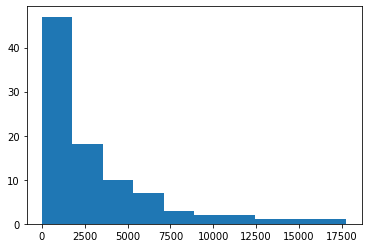

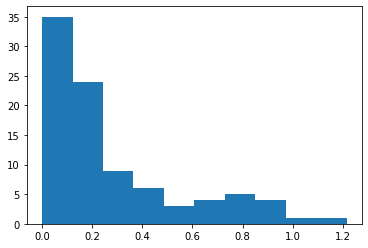

Series([], Name: tag, dtype: object)
Series([], Name: tag, dtype: object)


In [110]:
lob_prem["error_actual"] = [actuary_in_a_box("Actual", subset=[t])(fit_actual.x) for t in lob_prem.tag]
plt.hist(lob_prem.error_actual)
plt.show()

plt.hist(lob_prem.error_actual / np.sqrt(lob_prem.lob_prem))
plt.show()

print(lob_prem.tag[lob_prem.error_actual > 20e3])
print(lob_prem.tag[lob_prem.error_actual / np.sqrt(lob_prem.lob_prem) > 3])

In [111]:
# Average initial LR bias
np.mean(ult_year.bias_year[ult_year.year.apply(lambda x: x in range(1991, 2011))])

0.08222849188383156

In [112]:
# With change penalties
fit_opt = minimize(actuary_in_a_box("Accurate", apriori_lr_field="init_lr_unbiased_size", error_penalty_rel=4), [0.0])

fit_retro = minimize(actuary_in_a_box("Accurate", apriori_lr_field="init_lr_unbiased_size", retro_penalty=4), [0.0])

fit_both_pen = minimize(actuary_in_a_box("Accurate", apriori_lr_field="init_lr_unbiased_size", error_penalty_rel=4, retro_penalty=4), [0.0])

np.exp((
    fit_opt.x, fit_retro.x, fit_both_pen.x
))

array([[0.80584395],
       [0.74769347],
       [0.93047258]])

In [113]:
# Out of sample errors using 5-fold cross validation
num_folds = 5
tags_fold = tags.copy()
np.random.shuffle(tags_fold)
folds = np.array(np.array_split(tags_fold, num_folds), dtype = object)

error_actual = 0
error_accurate = 0

for fold in range(num_folds):
    fit_subset = np.concatenate(folds[np.array(range(num_folds)) != fold])
    
    fit_actual_temp = minimize(actuary_in_a_box("Actual", subset=fit_subset), [0.0])
    fit_accurate_temp = minimize(actuary_in_a_box("Accurate", apriori_lr_field="init_lr_unbiased_size", subset=fit_subset), [0.0])
    
    error_actual += actuary_in_a_box("Accurate", subset=folds[fold])(fit_actual_temp.x)
    error_accurate += actuary_in_a_box("Accurate", subset=folds[fold])(fit_accurate_temp.x)

error_hist = actuary_in_a_box("Accurate", subset=tags, apriori_lr_field="incurred_lr")([10])
(error_hist / 1e3, error_actual / 1e3, error_accurate / 1e3)
    

(468.4211760832941, 419.96154091306596, 215.24995030888434)

In [114]:
# By year group

r_actual_year = [np.exp(minimize(actuary_in_a_box("Actual", years = y), [0.0]).x) for y in year_groups]
r_accurate_year = [np.exp(minimize(actuary_in_a_box("Accurate", years = y), [0.0]).x) for y in year_groups]
r_accurate_nobias_year = [np.exp(minimize(actuary_in_a_box("Accurate", apriori_lr_field="init_lr_unbiased_size", years = y), [0.0]).x) for y in year_groups]

pd.DataFrame({
    "Years": year_groups, 
    "Bias": [np.mean(ult_year.bias_year[ult_year.year.apply(lambda x: x in y)]) for y in year_groups],
    "R Company": r_actual_year,
    "R Accurate": r_accurate_year,
    "R Accurate (Unbiased)": r_accurate_nobias_year,
})

,Years,Bias,R Company,R Accurate,R Accurate (Unbiased)
0,"(1991, 1992, 1993, 1994, 1995)",0.155250,[4.084421652315123],[0.9221050107254263],[1.4428005029640962]
1,"(1996, 1997, 1998, 1999, 2000)",-0.004554,[2.7857177737771206],[0.5429666679344679],[0.48878738413903233]
2,"(2001, 2002, 2003, 2004, 2005)",0.089966,[3.2295921342726657],[0.2893771350991792],[0.2389466668109473]
3,"(2006, 2007, 2008, 2009, 2010)",0.088253,[4.363650870680443],[0.765940793984473],[0.7763288446517465]


In [115]:
# By size group

tags_size = [
    list(lob_prem.tag[(lob_prem.size_group == s)])
    for s in range(num_size_groups) 
]

r_actual_size = [np.exp(minimize(actuary_in_a_box("Actual", subset=tags_size[s]), [0.0]).x[0]) for s in range(num_size_groups)]
r_accurate_size = [np.exp(minimize(actuary_in_a_box("Accurate", subset=tags_size[s]), [0.0]).x[0]) for s in range(num_size_groups)]
r_accurate_nobias_size = [np.exp(minimize(actuary_in_a_box("Accurate", apriori_lr_field="init_lr_unbiased_size", subset=tags_size[s]), [0.0]).x[0]) for s in range(num_size_groups)]

r_both_pen_small = [np.exp(minimize(actuary_in_a_box("Accurate", apriori_lr_field="init_lr_unbiased_size", subset=tags_size[s], error_penalty_rel=4, retro_penalty=4), [0.0]).x[0]) for s in range(num_size_groups)]                

pd.DataFrame({
    "Size": range(num_size_groups), 
    "Avg Pct": [np.mean(lob_prem.pct_lob[lob_prem.size_group == s]) for s in range(num_size_groups)],
    "Avg Size": [np.mean(lob_prem.lob_prem[lob_prem.size_group == s]) for s in range(num_size_groups)],
    "Bias": [np.mean(ult_year_size.bias_year_size[ult_year_size.size_group == s]) for s in range(num_size_groups)],
    "R Company": r_actual_size,
    "R Accurate": r_accurate_size,
    "R Accurate (Unbiased)": r_accurate_nobias_size,
    "R Opt": r_both_pen_small,
    "R Cpn / R Opt": np.array(r_actual_size) / np.array(r_both_pen_small),
})

,Size,Avg Pct,Avg Size,Bias,R Company,R Accurate,R Accurate (Unbiased),R Opt,R Cpn / R Opt
0,0,0.326605,4.197539e+07,0.126923,5.936770,0.302097,0.593852,1.048851,5.660261
1,1,0.403189,1.037314e+08,0.110430,3.328217,0.681457,0.648664,1.003087,3.317976
2,2,0.417432,4.586408e+08,0.039117,3.256584,0.553107,0.544321,0.842697,3.864478


In [116]:
# By LOB percentage group

tags_pct = [
    list(lob_prem.tag[(lob_prem.pct_group == s)])
    for s in range(num_size_groups) 
]

r_actual_pct = [np.exp(minimize(actuary_in_a_box("Actual", subset=tags_pct[s]), [0.0]).x[0]) for s in range(num_size_groups)]
r_accurate_pct = [np.exp(minimize(actuary_in_a_box("Accurate", subset=tags_pct[s]), [0.0]).x[0]) for s in range(num_size_groups)]
r_accurate_nobias_pct = [np.exp(minimize(actuary_in_a_box("Accurate", apriori_lr_field="init_lr_unbiased_size", subset=tags_pct[s]), [0.0]).x[0]) for s in range(num_size_groups)]

###r_both_pen_small = [np.exp(minimize(actuary_in_a_box("Accurate", apriori_lr_field="init_lr_unbiased_size", subset=tags_size[s], error_penalty_rel=4, retro_penalty=4), [0.0]).x) for s in range(num_size_groups)]                
r_both_pen_small = [np.exp(minimize(actuary_in_a_box("Accurate", subset=tags_pct[s], error_penalty_rel=4, retro_penalty=4), [0.0]).x[0]) for s in range(num_size_groups)]                

pd.DataFrame({
    "Pct": range(num_size_groups), 
    "Avg Pct": [np.mean(lob_prem.pct_lob[lob_prem.pct_group == s]) for s in range(num_size_groups)],
    "Avg Size": [np.mean(lob_prem.lob_prem[lob_prem.pct_group == s]) for s in range(num_size_groups)],
    "Bias": [np.mean(ult_year_pct.bias_year_pct[ult_year_pct.pct_group == s]) for s in range(num_size_groups)],
    "R Company": r_actual_pct,
    "R Accurate": r_accurate_pct,
    "R Accurate (Unbiased)": r_accurate_nobias_pct,
    "R Opt": r_both_pen_small,
})

,Pct,Avg Pct,Avg Size,Bias,R Company,R Accurate,R Accurate (Unbiased),R Opt
0,0,0.056108,1.732388e+08,0.046823,2.889821,0.742774,0.687599,1.029490
1,1,0.235131,2.291036e+08,0.083734,2.696537,0.360840,0.356915,0.686499
2,2,0.850567,2.060496e+08,0.120446,6.264705,0.662402,0.765894,1.263828


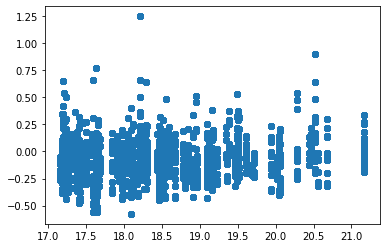

In [117]:

plt.scatter(np.log(tris_lob_df.lob_prem), tris_lob_df.bias)
plt.show()

In [118]:
# mutuals vs other
(
    np.exp(minimize(actuary_in_a_box("Actual", subset=mutuals), [0.0]).x[0]),
    np.exp(minimize(actuary_in_a_box("Actual", subset=non_mutuals), [0.0]).x[0])
)

(5.401600663407038, 3.080979140118098)

In [119]:
[np.mean(ult_year_mutual.bias_year_mutual[ult_year_mutual.mutual == x]) for x in [True, False]],

([0.10096410590589026, 0.06357037203816138],)

In [120]:
# back into implied penalties
pen_test = [1, 4, 6, 8, 10, 15, 20, 25, 50, 75, 100, 200, 300, 400, 500, 750, 1000]

log_r_opt = [
    minimize(actuary_in_a_box("Accurate", apriori_lr_field="init_lr_unbiased_size", error_penalty_rel=p), [0.0]).x
    for p in pen_test
]

log_r_retro = [
    minimize(actuary_in_a_box("Accurate", apriori_lr_field="init_lr_unbiased_size", retro_penalty=p), [0.0]).x
    for p in pen_test
]

(
    pen_test[np.argmin((log_r_opt - fit_actual.x) ** 2)],
    pen_test[np.argmin((log_r_retro - fit_actual.x) ** 2)],
)

(500, 200)

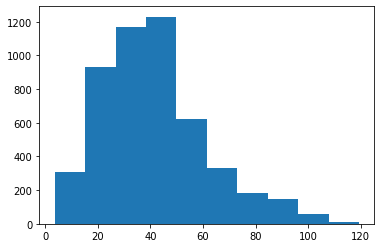

In [121]:
plt.hist(list(tris_lob_df[tris_lob_df.tag.apply(lambda x: x in list(lob_prem.tag[lob_prem.size_group == 0]))].earned_premium/1e6))
plt.show()

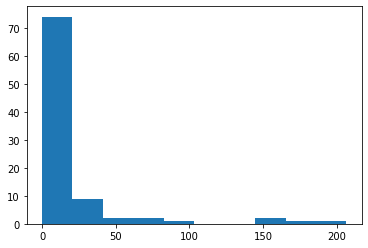

Series([], Name: tag, dtype: object)

In [122]:
log_r_actual_each = np.array([minimize(actuary_in_a_box("Actual", subset=t), [0.0]).x[0] for t in lob_prem.tag])
lob_prem["r_actual"] = np.exp(log_r_actual_each)

plt.hist(np.exp(log_r_actual_each))
plt.show()

lob_prem.tag[lob_prem.r_actual > 500]

## Loss Ratio Changes

In [123]:
evals = sorted(np.unique(tris_lob_df.evaluation_date))
years = sorted(np.unique(tris_lob_df.year))

In [124]:
tris_lob_df["incurred_lr_next"] = tris_lob_df.groupby(["tag", "eval_year"])["incurred_lr"].shift(-1)
tris_lob_df["incurred_lr_change"] = tris_lob_df.incurred_lr_next / tris_lob_df.incurred_lr - 1
tris_lob_df["incurred_lr_change"] = tris_lob_df["incurred_lr_change"].fillna(0)

rate_trend_df = tris_lob_df[["tag", "year", "incurred_lr_change"]][tris_lob_df.dev_lag == 0]
rate_trend_df = rate_trend_df.rename(columns={"incurred_lr_change": "rate_trend_change"})
rate_trend_df["rate_trend_factor"] = 1 + rate_trend_df.rate_trend_change
tris_lob_df = pd.merge(tris_lob_df, rate_trend_df, how="left", on=["tag", "year"])
tris_lob_df["cuml_rate_trend_factor"] = tris_lob_df.sort_values(["year"], ascending=False).groupby(["tag", "eval_year"])["rate_trend_factor"].cumprod()[::-1]
tris_lob_df["onlevel_ult_cl"] = tris_lob_df.ult_cl * tris_lob_df.cuml_rate_trend_factor
tris_lob_df["onlevel_incurred_lr"] = tris_lob_df.incurred_lr * tris_lob_df.cuml_rate_trend_factor


In [125]:
tris_lob_df["onlevel_ult_cl_prev"] = tris_lob_df.groupby(["tag", "eval_year"])["onlevel_ult_cl"].shift(1)
tris_lob_df["onlevel_ult_cl_change"] = tris_lob_df.onlevel_ult_cl / tris_lob_df.onlevel_ult_cl_prev - 1
tris_lob_df["onlevel_ult_cl_change"] = tris_lob_df["onlevel_ult_cl_change"].fillna(0)

tris_lob_df["onlevel_incurred_lr_prev"] = tris_lob_df.groupby(["tag", "eval_year"])["onlevel_incurred_lr"].shift(1)
tris_lob_df["onlevel_incurred_lr_change"] = tris_lob_df.onlevel_incurred_lr / tris_lob_df.onlevel_incurred_lr_prev - 1
tris_lob_df["onlevel_incurred_lr_change"] = tris_lob_df["onlevel_incurred_lr_change"].fillna(0)

#tris_lob_df.onlevel_incurred_lr_change[tris_lob_df.dev_lag == 0]

In [126]:
tris = tris_lob_df.copy()

In [127]:
def logit(x):
    return np.exp(x) / (1 + np.exp(x))


def inv_logit(x):
    return np.log(x / (1 - x))

In [128]:
# Generalized Cape-Cod method (Gluck 1997)

lr_field_map = {
    "Actual": "init_lr",
    "Actual Unbiased": "init_lr_unbiased",
    "Actual Unbiased Size": "init_lr_unbiased_size",
    "Accurate": "ult_true",
}

def gen_cc(params, tris, goal="Actual", double=False, use_incurred=False, cred_trend=True, start_year=1996, end_year=2011):
    
    lr_field = lr_field_map[goal]

    alpha = logit(params[0])
    
    # calculate decaying weights for expected lr and for trend
    if double:
        beta = logit(params[1])
        cred = logit(params[2]) if cred_trend else 1
        
        tris["w1"] = (tris.dev_lag > 0) * tris.earned_premium / tris.atu * alpha ** (tris.eval_year -  tris.year)
        tris["w2"] = (tris.dev_lag > 0) * (tris.earned_premium / tris.atu * beta ** (tris.eval_year -  tris.year))
    else:
        tris["w1"] = (tris.dev_lag > 0) * tris.earned_premium / tris.atu * alpha ** (tris.eval_year -  tris.year)
    
    if double:
        # exponential decay on lr change
        if use_incurred:
            tris["w2_x_change"] = tris.onlevel_incurred_lr_change * tris.w2 * cred
        else:
            tris["w2_x_change"] = tris.onlevel_ult_cl_change * tris.w2 * cred
        tris["cuml_w2"] = tris.groupby(["tag", "eval_year"])["w2"].cumsum()
        tris["cuml_w2_x_change"] = tris.groupby(["tag", "eval_year"])["w2_x_change"].cumsum()
        tris["pred_change"] = tris.cuml_w2_x_change / tris.cuml_w2
        tris["pred_change_factor"] = 1 + tris.pred_change
        tris["pred_cuml_change_factor"] = tris.sort_values(["year"], ascending=False).groupby(["tag", "eval_year"])["pred_change_factor"].cumprod()[::-1]
        if use_incurred:
            tris["trended_ult_cl"] = tris.onlevel_incurred_lr * tris.pred_cuml_change_factor
        else:
            tris["trended_ult_cl"] = tris.onlevel_ult_cl * tris.pred_cuml_change_factor
        

    # exponential decay on trended lrs (generalized cape-cod)
    if double:
        tris["w1_x_lr"] = tris.trended_ult_cl * tris.w1
    else:
        if use_incurred:
            tris["w1_x_lr"] = tris.onlevel_incurred_lr * tris.w1
        else:
            tris["w1_x_lr"] = tris.onlevel_ult_cl * tris.w1
    tris["cuml_w1"] = tris.groupby(["tag", "eval_year"])["w1"].cumsum()
    tris["cuml_w1_x_lr"] = tris.groupby(["tag", "eval_year"])["w1_x_lr"].cumsum()
    tris["pred_lr"] = tris.cuml_w1_x_lr / tris.cuml_w1
    
    # calculate total error
    f = (tris.dev_lag == 0) & (tris.year >= start_year) & (tris.year <= end_year)
    error = np.sum(np.sqrt(tris.earned_premium[f]) * (tris.pred_lr[f] - tris[lr_field][f]) ** 2)
    return error


In [129]:
# optimize to get company and most accurate values
x_actual = minimize(gen_cc, [0.0], args=(tris, "Actual")).x[0]
x_accurate = minimize(gen_cc, [0.0], args=(tris, "Accurate")).x[0]

f = (tris.dev_lag == 0) & (tris.year >= 1996)
hist_error = np.sum(np.sqrt(tris.earned_premium[f]) * (tris.ult_true[f] - tris.init_lr[f]) ** 2)

pd.DataFrame({
    "type": ["historical", "actual", "accurate"],
    "x": logit([np.nan, x_actual, x_accurate]),
    "accuracy error": [
        hist_error/1e3, 
        gen_cc([x_actual], tris, "Accurate")/1e3, 
        gen_cc([x_accurate], tris, "Accurate")/1e3, 
    ],
    "booking error": [
        0, 
        gen_cc([x_actual], tris, "Actual")/1e3, 
        gen_cc([x_accurate], tris, "Actual")/1e3, 
    ],
})

,type,x,accuracy error,booking error
0,historical,NaN,257.136044,0.000000
1,actual,8.123357e-01,306.238165,286.940232
2,accurate,6.799568e-08,180.823822,317.804172


In [130]:
# Out of sample errors using 5-fold cross validation

num_years_fit = 10

error_actual = 0
error_accurate = 0

for test_year in range(1996, 2011):
    t = tris.copy()[(tris.year < test_year) & (tris.year >= test_year - num_years_fit)]
    fit_actual_temp = minimize(gen_cc, [0.0], args=(t, "Actual"))
    fit_accurate_temp = minimize(gen_cc, [0.0], args=(t, "Accurate"))
    
    t = tris.copy()[(tris.year <= test_year) & (tris.year >= test_year - num_years_fit)]
    error_actual += gen_cc(fit_actual_temp.x, t, "Accurate", start_year=test_year, end_year=test_year)
    error_accurate += gen_cc(fit_accurate_temp.x, t, "Accurate", start_year=test_year, end_year=test_year)

f = (tris.dev_lag == 0) & (tris.year >= 1996)
error_hist = np.sum(np.sqrt(tris.earned_premium[f]) * (tris.ult_true[f] - tris.init_lr[f]) ** 2)

(
    error_hist/1e3,
    error_actual/1e3,
    error_accurate/1e3,
)

(257.13604443220294, 270.2771793519901, 182.582031008378)

In [131]:
# Out of sample errors - taking into account size groups

num_years_fit = 10

error_actual = 0
error_accurate = 0

for test_year in range(1996, 2011):
    t = tris[(tris.year < test_year) & (tris.year >= test_year - num_years_fit)]
    x_actual_temp = [minimize(gen_cc, [0.0], args=(t[t.size_group == s].copy(), "Actual")).x for s in range(num_size_groups)]
    x_accurate_temp = [minimize(gen_cc, [0.0], args=(t[t.size_group == s].copy(), "Accurate")).x for s in range(num_size_groups)]
    
    t = tris[(tris.year <= test_year) & (tris.year >= test_year - num_years_fit)]
    error_actual += np.sum([gen_cc(x_actual_temp[s], t[t.size_group == s].copy(), "Accurate", start_year=test_year, end_year=test_year) for s in range(num_size_groups)])
    error_accurate += np.sum([gen_cc(x_accurate_temp[s], t[t.size_group == s].copy(), "Accurate", start_year=test_year, end_year=test_year) for s in range(num_size_groups)])

f = (tris.dev_lag == 0) & (tris.year >= 1996)
error_hist = np.sum(np.sqrt(tris.earned_premium[f]) * (tris.ult_true[f] - tris.init_lr[f]) ** 2)

(
    error_hist/1e3,
    error_actual/1e3,
    error_accurate/1e3,
)

(257.13604443220294, 273.31458374555325, 181.9884881707183)

In [132]:
x_actual_size = [minimize(gen_cc, [0.0], args=(tris[tris.size_group == s].copy(), "Actual")).x[0] for s in range(num_size_groups)]
x_accurate_size = [minimize(gen_cc, [0.0], args=(tris[tris.size_group == s].copy(), "Accurate")).x[0] for s in range(num_size_groups)]

pd.DataFrame({
    "Size Group": range(num_size_groups), 
    "Actual": logit(x_actual_size), 
    "Accurate": logit(x_accurate_size),
})

,Size Group,Actual,Accurate
0,0,0.474323,1.740944e-01
1,1,0.346467,1.092201e-03
2,2,0.942683,2.197212e-13


In [133]:
x_actual_account = [minimize(gen_cc, [0.0], args=(tris[tris.tag == t].copy(), "Actual")).x[0] for t in tags]
x_accurate_account = [x_accurate_size[s] for s in lob_prem.size_group]

In [134]:
# output table to combine LOBs for regression
d = pd.concat((lob_prem, pd.DataFrame({"x_actual_account": logit(x_actual_account)}), pd.DataFrame({"x_accurate_account": logit(x_accurate_account)})), axis=1)
d = pd.merge(d, pd.DataFrame({"size_group": [0,1,2], "x_accurate_size": logit(x_accurate_size)}), how="left", on=["size_group"])
d.to_csv(f"{lob}_reg.csv")

In [152]:
# read in CSV files from each LOB
reg_combined = None
for l in ["WC", "OO", "CA", "OC"]:
    temp = pd.read_csv(f"{l}_reg.csv")
    reg_combined = pd.concat((reg_combined, temp))


In [153]:
reg_combined["mutual"] = reg_combined.tag.apply(lambda x: 1 if x in mutuals_all else 0)

In [154]:
# combined regression
X = dmatrix("1 + lob + np.log(lob_prem) + pct_lob", reg_combined)
y = np.maximum(-3, np.log(reg_combined.r_actual))

fit_r = sm.OLS(y, X).fit()
print(fit_r.summary())

                            OLS Regression Results                            
Dep. Variable:               r_actual   R-squared:                       0.090
Model:                            OLS   Adj. R-squared:                  0.071
Method:                 Least Squares   F-statistic:                     4.611
Date:                Tue, 03 May 2022   Prob (F-statistic):           0.000496
Time:                        13:16:46   Log-Likelihood:                -435.63
No. Observations:                 239   AIC:                             883.3
Df Residuals:                     233   BIC:                             904.1
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.8421      1.873      2.051      0.0

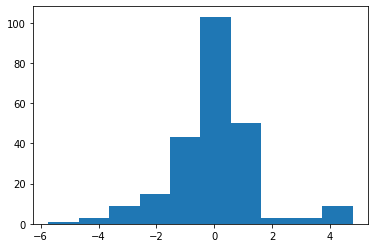

In [155]:
resid = (fit_r.predict(X) - y)
plt.hist(resid)
plt.show()

In [158]:
# percent of mutuals
len(np.unique(reg_combined.tag[reg_combined.mutual == 1])) / len(np.unique(reg_combined.tag))

0.22151898734177214

In [160]:
# with mutual flag
f = np.log(reg_combined.r_actual) > -3
X = dmatrix("1 + lob + np.log(lob_prem) + pct_lob + mutual", reg_combined[f])
y = np.maximum(-3, np.log(reg_combined.r_actual[f]))

fit_r_mutual = sm.OLS(y, X).fit()
print(fit_r_mutual.summary())

                            OLS Regression Results                            
Dep. Variable:               r_actual   R-squared:                       0.151
Model:                            OLS   Adj. R-squared:                  0.128
Method:                 Least Squares   F-statistic:                     6.516
Date:                Tue, 03 May 2022   Prob (F-statistic):           2.40e-06
Time:                        13:19:25   Log-Likelihood:                -353.93
No. Observations:                 227   AIC:                             721.9
Df Residuals:                     220   BIC:                             745.8
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.3941      1.462      3.005      0.0

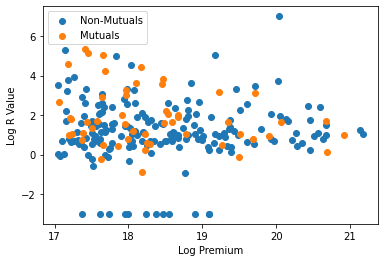

In [161]:
plt.scatter(np.log(reg_combined.lob_prem[reg_combined.mutual == False]), np.maximum(-3, np.log(reg_combined.r_actual[reg_combined.mutual == False])), label="Non-Mutuals")
plt.scatter(np.log(reg_combined.lob_prem[reg_combined.mutual == True]), np.maximum(-3, np.log(reg_combined.r_actual[reg_combined.mutual == True])), label="Mutuals")
plt.legend()
plt.xlabel("Log Premium")
plt.ylabel("Log R Value")
plt.show()

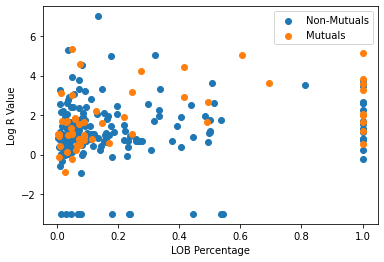

In [162]:
plt.scatter(reg_combined.pct_lob[reg_combined.mutual == False], np.maximum(-3, np.log(reg_combined.r_actual[reg_combined.mutual == False])), label="Non-Mutuals")
plt.scatter(reg_combined.pct_lob[reg_combined.mutual == True], np.maximum(-3, np.log(reg_combined.r_actual[reg_combined.mutual == True])), label="Mutuals")
plt.legend()
plt.xlabel("LOB Percentage")
plt.ylabel("Log R Value")
plt.show()

### Evaluate changes, etc.

In [148]:
tris_lob_df["incurred_lr_change_age"] = tris_lob_df.incurred_lr - tris_lob_df.groupby(["tag", "year"])["incurred_lr"].shift(1)
tris_lob_df["incurred_lr_change_age"] = tris_lob_df["incurred_lr_change_age"].fillna(0)

tris_lob_df["earned_premium_change"] = tris_lob_df.earned_premium - tris_lob_df.groupby(["tag", "year"])["earned_premium"].shift(1)
tris_lob_df["earned_premium_change"] = tris_lob_df["earned_premium_change"].fillna(0)

z = tris_lob_df.atu ** - np.exp(fit_actual.x[0])
z = np.array([0 if d == 0 else zi for zi, d in zip(z, tris_lob_df.dev_lag)])
tris_lob_df["ult_ind_actual"] = z * tris_lob_df.ult_cl + (1 - z) * tris_lob_df.init_lr

z = tris_lob_df.atu ** - np.exp(fit_accurate.x[0])
z = np.array([0 if d == 0 else zi for zi, d in zip(z, tris_lob_df.dev_lag)])
tris_lob_df["ult_ind_accurate"] = z * tris_lob_df.ult_cl + (1 - z) * tris_lob_df.init_lr

tris_lob_df["ult_ind_actual_change"] = tris_lob_df.ult_ind_actual - tris_lob_df.groupby(["tag", "year"])["ult_ind_actual"].shift(1)
tris_lob_df["ult_ind_actual_change"] = tris_lob_df["ult_ind_actual_change"].fillna(0)

tris_lob_df["ult_ind_accurate_change"] = tris_lob_df.ult_ind_accurate - tris_lob_df.groupby(["tag", "year"])["ult_ind_accurate"].shift(1)
tris_lob_df["ult_ind_accurate_change"] = tris_lob_df["ult_ind_accurate_change"].fillna(0)

tris_lob_df["incurred_lr_change_true"] = tris_lob_df.ult_true - tris_lob_df.incurred_lr
tris_lob_df["ult_ind_actual_change_true"] = tris_lob_df.ult_true - tris_lob_df.ult_ind_actual
tris_lob_df["ult_ind_accurate_change_true"] = tris_lob_df.ult_true - tris_lob_df.ult_ind_accurate

tris_lob_df["incurred_lr_change_amt"] = tris_lob_df.incurred_lr_change_age * tris_lob_df.earned_premium
tris_lob_df["ult_ind_actual_change_amt"] = tris_lob_df.ult_ind_actual_change * tris_lob_df.earned_premium
tris_lob_df["ult_ind_accurate_change_amt"] = tris_lob_df.ult_ind_accurate_change * tris_lob_df.earned_premium

tris_lob_df["incurred_lr_change_true_amt"] = tris_lob_df.incurred_lr_change_true * tris_lob_df.earned_premium
tris_lob_df["ult_ind_actual_change_true_amt"] = tris_lob_df.ult_ind_actual_change_true * tris_lob_df.earned_premium
tris_lob_df["ult_ind_accurate_change_true_amt"] = tris_lob_df.ult_ind_accurate_change_true * tris_lob_df.earned_premium

tris_lob_df["incurred_lr_change_amt_sq"] = tris_lob_df["incurred_lr_change_amt"] ** 2
tris_lob_df["ult_ind_actual_change_amt_sq"] = tris_lob_df["ult_ind_actual_change_amt"] ** 2
tris_lob_df["ult_ind_accurate_change_amt_sq"] = tris_lob_df["ult_ind_accurate_change_amt"] ** 2

tris_lob_df["incurred_lr_change_amt_abs"] = abs(tris_lob_df["incurred_lr_change_amt"])
tris_lob_df["ult_ind_actual_change_amt_abs"] = abs(tris_lob_df["ult_ind_actual_change_amt"])
tris_lob_df["ult_ind_accurate_change_amt_abs"] = abs(tris_lob_df["ult_ind_accurate_change_amt"])


In [149]:
# stdev of wrong dir changes reduction

thr = 0.0

incurred_lr_change_wrong_dir = [c ** 2 if (np.sign(c) != np.sign(t)) and (abs(p) > thr) else 0 for p, c, t in zip(tris_lob_df.incurred_lr_change_age, tris_lob_df.incurred_lr_change_amt, tris_lob_df.incurred_lr_change_true_amt)]
ult_true_actual_change_wrong_dir = [c ** 2 if np.sign(c) != np.sign(t) and (abs(p) > thr) else 0 for p, c, t in zip(tris_lob_df.ult_ind_actual_change, tris_lob_df.ult_ind_actual_change_amt, tris_lob_df.ult_ind_actual_change_true_amt)]
ult_true_accurate_change_wrong_dir = [c ** 2 if np.sign(c) != np.sign(t) and (abs(p) > thr) else 0 for p, c, t in zip(tris_lob_df.ult_ind_accurate_change, tris_lob_df.ult_ind_accurate_change_amt, tris_lob_df.ult_ind_accurate_change_true_amt)]

print((
    np.sqrt(np.sum(incurred_lr_change_wrong_dir))/1e6,
    np.sqrt(np.sum(ult_true_actual_change_wrong_dir))/1e6,
    np.sqrt(np.sum(ult_true_accurate_change_wrong_dir))/1e6,
))

print((
    np.sqrt(np.sum(incurred_lr_change_wrong_dir)) / np.sqrt(np.sum(ult_true_accurate_change_wrong_dir)) - 1,
    np.sqrt(np.sum(ult_true_actual_change_wrong_dir)) / np.sqrt(np.sum(ult_true_accurate_change_wrong_dir)) - 1
))


(458.86268998470564, 252.71664670777278, 933.1243575202448)
(-0.5082512997473112, -0.7291715250265665)


In [150]:
# CY level
cy_tris_lob_df = tris_lob_df[(tris_lob_df.dev_lag > 0) & (tris_lob_df.eval_year > 1995) & (tris_lob_df.eval_year <=2010)].groupby(["tag", "eval_year"])[["incurred_lr_change_amt", "ult_ind_actual_change_amt", "ult_ind_accurate_change_amt", "earned_premium_change"]].sum().reset_index()

ay = tris_lob_df[tris_lob_df.dev_lag == 0][["tag", "year", "earned_premium", "incurred_lr"]].rename(columns={"year": "eval_year", "earned_premium": "ay_earned_premium", "incurred_lr": "ay_incurred_lr"})
cy_tris_lob_df = pd.merge(cy_tris_lob_df, ay, how="left", on=["tag", "eval_year"])

cy_tris_lob_df["cy_earned_premium"] = cy_tris_lob_df.ay_earned_premium + cy_tris_lob_df.earned_premium_change
cy_tris_lob_df["cy_incurred_lr"] = (cy_tris_lob_df.ay_incurred_lr * cy_tris_lob_df.ay_earned_premium + cy_tris_lob_df.incurred_lr_change_amt) / cy_tris_lob_df.cy_earned_premium

cy_tris_lob_df["incurred_lr_change_age"] = cy_tris_lob_df["incurred_lr_change_amt"] / cy_tris_lob_df.cy_earned_premium
cy_tris_lob_df["ult_ind_actual_change"] = cy_tris_lob_df["ult_ind_actual_change_amt"] / cy_tris_lob_df.cy_earned_premium
cy_tris_lob_df["ult_ind_accurate_change"] = cy_tris_lob_df["ult_ind_accurate_change_amt"] / cy_tris_lob_df.cy_earned_premium



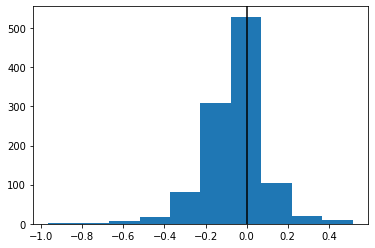

0.08445045838650676
-0.12487645117105783
1.4786947703650382

339
740
0.31417979610750696


In [151]:
plt.hist(cy_tris_lob_df.incurred_lr_change_age)
plt.axvline(0, color="black")
plt.show()

mean_adv = np.mean(cy_tris_lob_df.incurred_lr_change_age[cy_tris_lob_df.incurred_lr_change_age > 0])
mean_fav = np.mean(cy_tris_lob_df.incurred_lr_change_age[cy_tris_lob_df.incurred_lr_change_age < 0])
print(mean_adv)
print(mean_fav)
print(abs(mean_fav) / mean_adv)
print("")

num_adv = np.sum(cy_tris_lob_df.incurred_lr_change_age > 0)
num_fav = np.sum(cy_tris_lob_df.incurred_lr_change_age < 0)
print(num_adv)
print(num_fav)
print(num_adv / (num_adv + num_fav))
